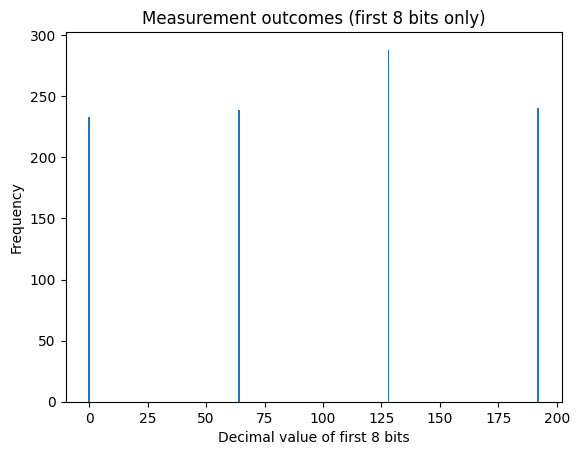

Top results (sorted):
128 → 288 times
192 → 240 times
 64 → 239 times
  0 → 233 times


In [4]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

NUM_TOTAL_QUBITS = 12
NUM_CONTROL_QUBITS = 8
TARGET_QUBITS = [8, 9, 10, 11]
REPEATS = 1000

def build_full_U_xmodN(x=2, N=15):
    dim = 2**12
    U = np.eye(dim, dtype=complex)

    for a in range(2**8):
        result = pow(x, a, N)
        for t in range(2**4):
            idx_in = (a << 4) | t
            idx_out = (a << 4) | (result if t == 1 else t)
            if idx_in != idx_out:
                U[idx_out, idx_in] = 1
                U[idx_in, idx_in] = 0

    return U

def inverse_qft(wires):
    n = len(wires)
    for i in range(n // 2):
        qml.SWAP(wires=[wires[i], wires[n - i - 1]])
    for i in reversed(range(n)):
        for j in reversed(range(i + 1, n)):
            qml.ctrl(qml.PhaseShift(-np.pi / 2 ** (j - i), wires=wires[j]), control=wires[i])
        qml.Hadamard(wires=wires[i])

dev = qml.device("default.qubit", wires=NUM_TOTAL_QUBITS, shots=REPEATS)

U = build_full_U_xmodN()

@qml.qnode(dev)
def shor_full_circuit():
    for i in range(NUM_CONTROL_QUBITS):
        qml.Hadamard(wires=i)

    qml.PauliX(wires=11)

    qml.QubitUnitary(U, wires=range(NUM_TOTAL_QUBITS))

    inverse_qft(list(range(NUM_CONTROL_QUBITS)))

    return qml.sample(wires=range(NUM_TOTAL_QUBITS))

samples = shor_full_circuit()
bitstrings = ["".join(str(bit) for bit in sample[:NUM_CONTROL_QUBITS]) for sample in samples]
counts = Counter(bitstrings)
decimal_counts = Counter(int(b, 2) for b in bitstrings)

# Plot
plt.bar(decimal_counts.keys(), decimal_counts.values())
plt.xlabel("Decimal value of first 8 bits")
plt.ylabel("Frequency")
plt.title("Measurement outcomes (first 8 bits only)")
plt.show()

# Print top results
print("Top results (sorted):")
for value, count in decimal_counts.most_common():
    print(f"{value:3d} → {count} times")


In [6]:
from fractions import Fraction

def find_candidate_rs(measured_values, n_bits):
    candidates = set()
    for value in measured_values:
        frac = Fraction(value, 2 ** n_bits).limit_denominator(256)
        r = frac.denominator
        candidates.add(r)
        print(f"Measured value: {value} → Fraction: {frac} → Candidate r: {r}")
    return sorted(candidates)

top_values = [0, 64, 128, 192]
n_bits = 8

candidate_rs = find_candidate_rs(top_values, n_bits)
print("r:", candidate_rs)


Measured value: 0 → Fraction: 0 → Candidate r: 1
Measured value: 64 → Fraction: 1/4 → Candidate r: 4
Measured value: 128 → Fraction: 1/2 → Candidate r: 2
Measured value: 192 → Fraction: 3/4 → Candidate r: 4
r: [1, 2, 4]


In [5]:
import math

def shor_find_factors(x, N, r):    
    if r % 2 != 0:
        print("Period r must be even. Try again.")
        return None

    xr2 = pow(x, r // 2, N)
    if xr2 == N - 1 or xr2 == 1:
        print("Trivial factor found; try a different x.")
        return None

    factor1 = math.gcd(xr2 - 1, N)
    factor2 = math.gcd(xr2 + 1, N)

    if factor1 in (1, N) or factor2 in (1, N):
        print("Only trivial factors found.")
        return None

    return factor1, factor2

factors = shor_find_factors(x=2, N=15, r=4)
print("Nontrivial factors:", factors)


Nontrivial factors: (3, 5)
